In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
from itertools import combinations
import seaborn as sns
import sys
sys.path.insert(0, r"C:\Users\achil\GIN Dropbox\Achille Gillig\tools\neuroginius")
from neuroginius.plotting import plot_matrix
from neuroginius.atlas import Atlas
from nilearn.maskers import NiftiLabelsMasker
from nilearn.plotting import plot_stat_map


atlas = Atlas().from_name("schaefer200")

[get_dataset_dir] Dataset found in C:\Users\achil\nilearn_data\schaefer_2018

In [2]:
def to_matrix(vec):
    n = int(np.sqrt(len(vec) * 2))
    mat = np.zeros((n, n))
    mat[np.triu_indices(n, k=0)] = vec
    mat += mat.T
    np.fill_diagonal(mat, np.diag(mat) / 2)
    return mat

def binarize(matrix):
    pos_matrix = np.zeros_like(matrix)
    neg_matrix = np.zeros_like(matrix)

    pos_matrix[matrix > 0] = 1
    neg_matrix[matrix < 0] = 1
    return pos_matrix, neg_matrix

def degree_centrality(matrix):
    pos_matrix, neg_matrix = binarize(matrix)
    pos_degree = pos_matrix.sum(axis=0)
    neg_degree = neg_matrix.sum(axis=0)
    return pos_degree, neg_degree

def matrix_to_chord(matrix, atlas, percentile=99.8,
                    diverging=False, 
                    positive_only=True,
                    RSN_to_color=None, title=None,
                    filename=None):
    from nichord.convert import convert_matrix
    from nichord.chord import plot_chord, plot_arcs
    from nichord.coord_labeler import get_idx_to_label


    RSNs = np.unique(atlas.macro_labels)
    idx_to_label = {i: RSN for i, RSN in enumerate(np.unique(atlas.macro_labels))}

    # tmp_coefs = MatrixResult(squareform(cluster_coefs[9]), atlas).get_macro_matrix().values
    tmp_coefs = matrix.copy()
    if percentile is not None:
        perc_thr = np.percentile(tmp_coefs, percentile)
    else:
        perc_thr = -np.inf
    
    vmin, vmax = None, None
    if diverging:
        cmap = 'RdBu_r'
        vmin = np.min(tmp_coefs)
        vmax = np.max(tmp_coefs) 
        vmax = np.max((np.abs(vmin), np.abs(vmax)))
        vmin = -vmax
        # tmp_coefs[np.abs(tmp_coefs) < perc_thr] = 0
    else:
        if positive_only:
            vmin = 0
            cmap = 'Reds'
            tmp_coefs[tmp_coefs < perc_thr] = 0
        else:
            vmax = 0
            vmin = None
            cmap = 'Blues'
            tmp_coefs[tmp_coefs > -perc_thr] = 0

    
    edges, edge_weights = convert_matrix(tmp_coefs)

    # fp_chord = 'tmp.png'
    fp_chord = filename
    max_linewidth = 8
    scaling_factor = max_linewidth / edge_weights.max()
    plot_chord(idx_to_label, edges, edge_weights=edge_weights, fp_chord=fp_chord, 
            network_colors=RSN_to_color,
            linewidths=(edge_weights * scaling_factor).tolist(), alphas=0.9, do_ROI_circles=True, label_fontsize=24, 
            # July 2023 update allows changing label fontsize
            do_ROI_circles_specific=False, ROI_circle_radius=0.01,
            # cmap='RdBu_r',
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            do_monkeypatch=True,
            black_BG=True,
            plot_count=False,
            arc_setting=False,
            dpi=600,
            # edge_threshold=5
            )
    if title is not None:
        plt.title(f'{title}', fontsize=10)
    # plt.show()

In [3]:
from scipy.stats import norm
from sklearn.utils import Bunch

def signed_stouffer(pvalues, original_stat):
    Zi = norm.isf(pvalues / 2) # Divide by 2 for two-tailed test
    k = len(pvalues)
    sign_mask = np.where(original_stat < 0, -1, 1)
    Z = np.sum(Zi * sign_mask) / np.sqrt(k)
    p_global = norm.sf(np.abs(Z)) * 2  # Convert to p-value
    res = Bunch(pvalue=p_global, statistic=Z)
    return res


In [4]:
data_dir = Path(r"C:\Users\achil\GIN Dropbox\Achille Gillig\shared\Jonathan_Achille_Shared\memento_data")
n_perm = 1000
mat_file = data_dir / f"{n_perm}perm_mean_tangent_patterns.joblib"
perm_mat_file = data_dir / f"{n_perm}perm_mean_tangent_perm_patterns.joblib"

with open(mat_file, 'rb') as f:
    haufe_matrices = joblib.load(f)

with open(perm_mat_file, 'rb') as f:
    perm_haufe_matrices = joblib.load(f)
    

<Axes: >

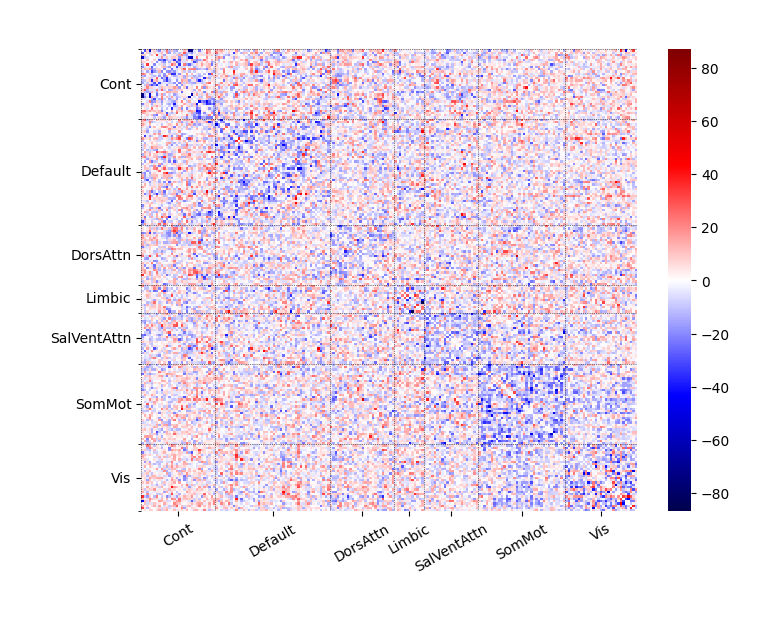

In [5]:
plot_matrix(haufe_matrices.squeeze(), atlas)

In [7]:
conn_measure = joblib.load(r"C:\Users\achil\GIN Dropbox\Achille Gillig\Projects\memento\article-figures\connectivity_measure.joblib")

diff_matrices = {}
ambient_diff_matrices = {}
null_diff_matrices = {}
#step 1: creation of class differences matrices
classes = ['stable', 'decline']

# tangent_haufe_matrices = haufe_matrices.copy()
ambient_haufe_matrices = conn_measure.inverse_transform(haufe_matrices / 1e4)
# ambient_perm_matrices = []
# tangent_perm_haufe_matrices = perm_haufe_matrices.copy()
# for haufe_mat_array in tangent_perm_haufe_matrices:
#     ambient_perm_matrices.append(conn_measure.inverse_transform(haufe_mat_array / 1e4))
# perm_haufe_matrices = np.array(ambient_perm_matrices)


for class1, class2 in combinations(classes, 2):
    print(f"Calculating difference for classes: {class2} - {class1}")
    i = classes.index(class1)
    j = classes.index(class2)

    # Calculate the difference matrix
    diff_matrices[class2, class1] = haufe_matrices.squeeze()
    


    ambient_diff_matrices[class2, class1] = ambient_haufe_matrices.squeeze()


    tmp_null_diff = []
    n_perm = perm_haufe_matrices.shape[0]
    for iter in range(n_perm):
        perm_mat1 = perm_haufe_matrices[iter, i]
        
        tmp_null_diff.append(perm_mat1)
    
    null_diff_matrices[class2, class1] = np.array(tmp_null_diff)

    


Calculating difference for classes: decline - stable


c:\Users\achil\anaconda3\envs\dynapred\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LedoitWolf from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
def nonparametric_p_value(empirical_matrix, null_matrices, alternative='two-sided'):
    """
    Calculate the p-value for the empirical matrix against the null distribution.
    
    Parameters:
    - empirical_matrix: The observed difference matrix.
    - null_matrix: The null distribution of differences.
    - alternative: 'two-sided', 'greater', or 'less'.
    
    Returns:
    - p-value as a numpy array.
    """
    if alternative == 'two-sided':
        # eps = 1e-4
        # pvalue = (np.sum(np.abs(null_matrices) >= np.abs(empirical_matrix), axis=0)) / (null_matrices.shape[0]) + eps
        # return np.where(pvalue > 1, 1, pvalue)  # Ensure p-values are capped at 1
        # return (1 + np.sum(np.abs(null_matrices) >= np.abs(empirical_matrix), axis=0)) / (1 + null_matrices.shape[0])
        N = null_matrices.shape[0]
        pvalues_more = (np.sum(empirical_matrix > null_matrices, axis=0) + 1) / (N + 1)
        pvalues_less = (np.sum(empirical_matrix <  null_matrices, axis=0) + 1) / (N + 1)
        pvalues = np.minimum(pvalues_less, pvalues_more) * 2
        return np.clip(pvalues, 0, .9999) # Sometimes p-values can be slightly above 1 due to the *2 factor above
    elif alternative == 'greater':
        print('to modify')
        return np.mean(null_matrices >= empirical_matrix, axis=0)
    elif alternative == 'less':
        print('to modify')
        return np.mean(null_matrices <= empirical_matrix, axis=0)
    else:
        raise ValueError("Alternative must be 'two-sided', 'greater', or 'less'.")

Calculating p-values for classes: decline - stable


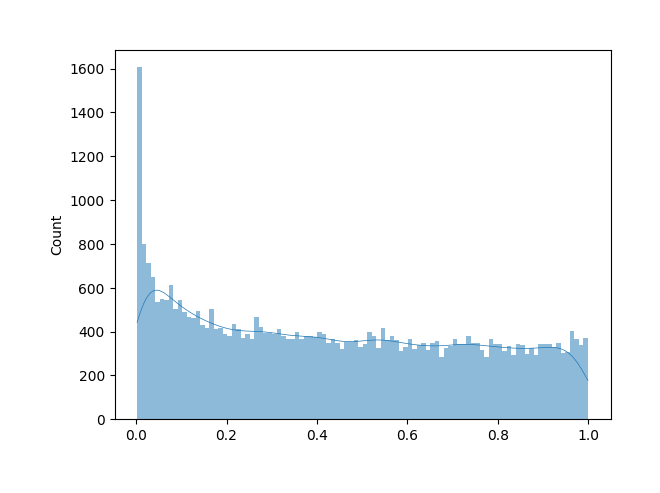

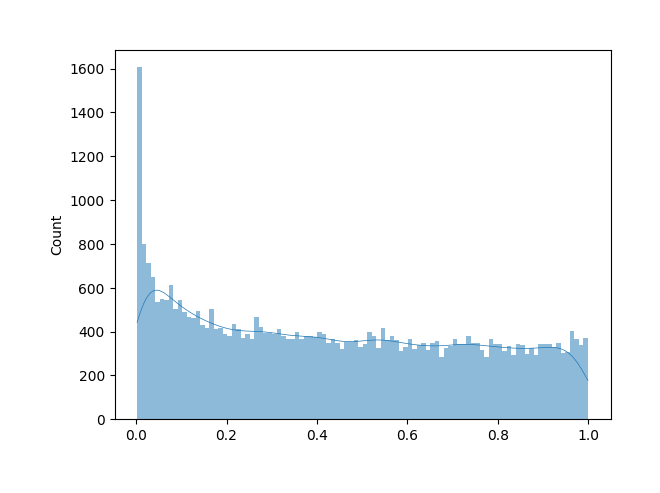

In [9]:
corrected_null_distribution = np.array([mat for mat in null_diff_matrices.values()]).max(axis=0)
p_values = {}
corrected_p_values = {}
class2, class1 = classes[1], classes[0]
print(f"Calculating p-values for classes: {class2} - {class1}")
diff_matrix = diff_matrices[class2, class1]
null_diff_matrix = null_diff_matrices[class2, class1]

# Calculate p-values
p_values[class2, class1] = nonparametric_p_value(diff_matrix, null_diff_matrix, alternative='two-sided')
corrected_p_values[class2, class1] = nonparametric_p_value(diff_matrix, corrected_null_distribution, alternative='two-sided')
sns.histplot(p_values[class2, class1].flatten(), bins=100, kde=True)
plt.show()
for cor_ps in corrected_p_values.values():
    sns.histplot(cor_ps.flatten(), bins=100, kde=True)
plt.show()

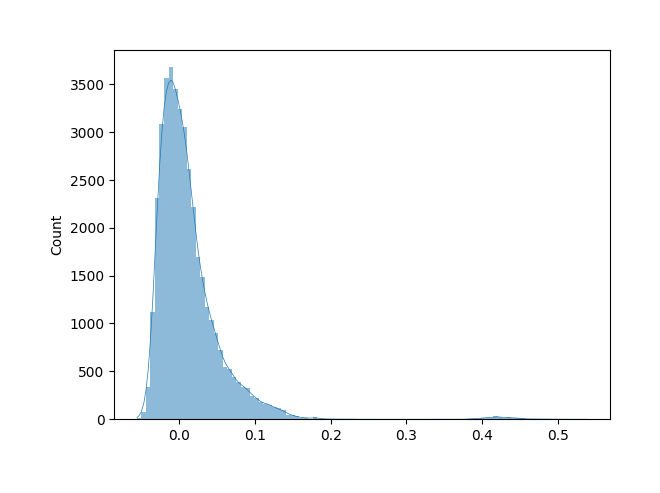

In [10]:
for combination in diff_matrices.keys():
    sns.histplot(ambient_diff_matrices[combination].flatten(), bins=100, kde=True)

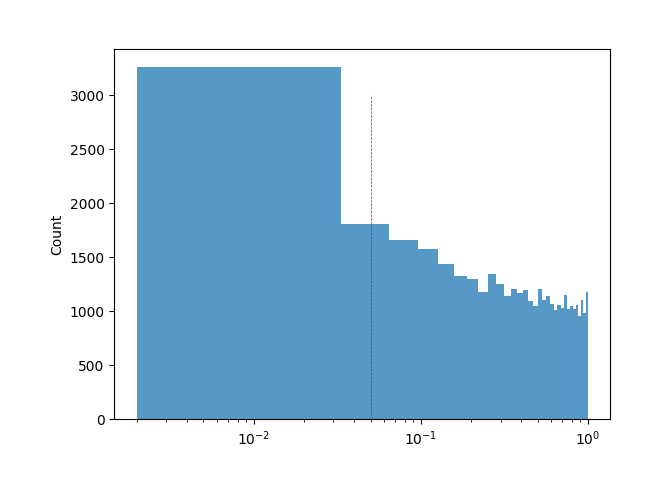

In [11]:
sns.histplot(p_values['decline', 'stable'].ravel())
plt.xscale('log')
plt.vlines(0.05, 0, 3000, color='red', linestyle='--')

In [12]:
from matplotlib.ticker import FixedLocator        

def set_network_ticks(axes, atlas):
    networks = np.array(atlas.macro_labels)
    sort_index = np.argsort(networks)
    n_regions = len(networks)
    ticks = []
    lbls = []
    prev_label = None
    for i, label in enumerate(networks[sort_index]):
        if label != prev_label:
            ticks.append(i)
            lbls.append(label)
            prev_label = label
            axes.hlines(i, 0, n_regions, colors="black", linestyles="dotted")
            axes.vlines(i, 0, n_regions, colors="black", linestyles="dotted")

    ticks.append(i + 1)

    axes.yaxis.set_minor_locator(FixedLocator(ticks))
    axes.yaxis.set_major_locator(FixedLocator([(t0 + t1) / 2 for t0, t1 in zip(ticks[:-1], ticks[1:])]))
    axes.xaxis.set_major_locator(FixedLocator([(t0 + t1) / 2 for t0, t1 in zip(ticks[:-1], ticks[1:])]))
    axes.set_yticklabels(lbls, rotation=0, fontsize=12)
    axes.set_xticklabels(lbls, rotation=30, fontsize=12)

In [13]:
np.fill_diagonal(p_values[('decline', 'stable')], .999)

[get_dataset_dir] Dataset found in C:\Users\achil\nilearn_data\schaefer_2018

<Axes: >

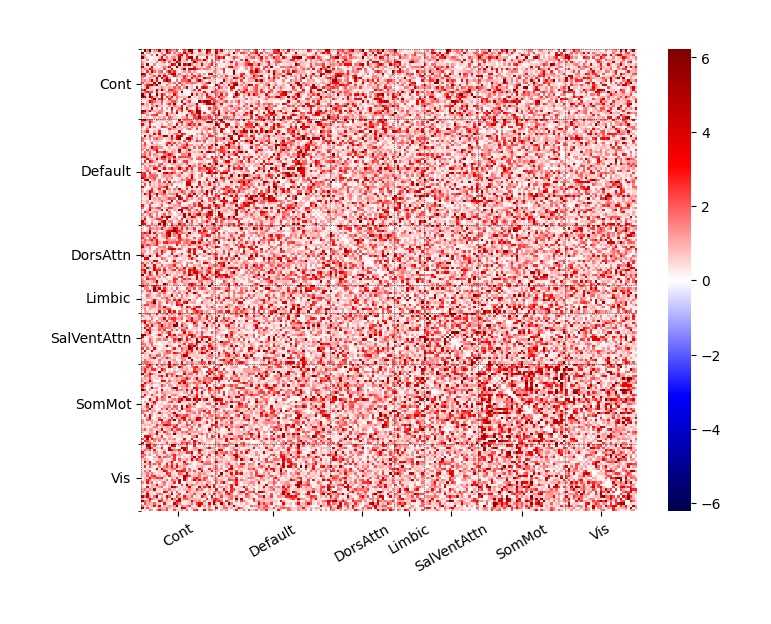

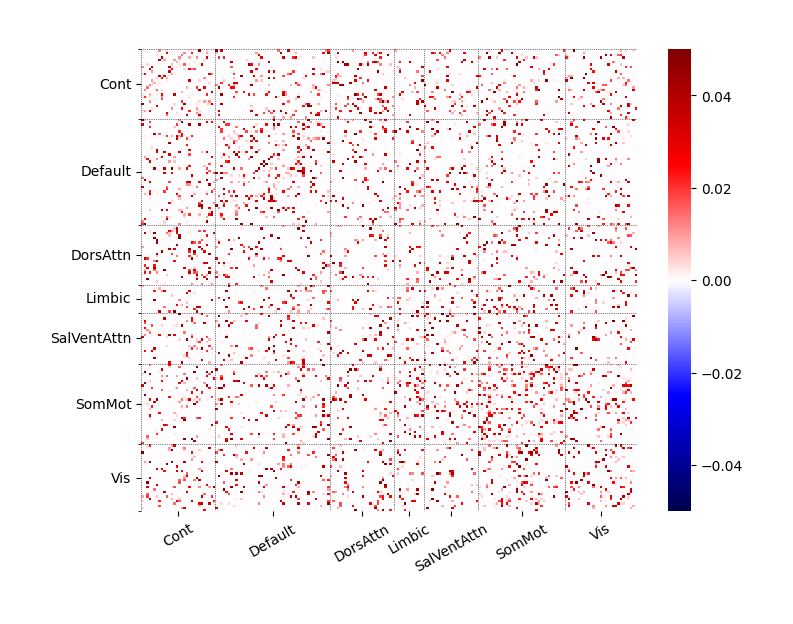

In [14]:
atlas = Atlas.from_name("schaefer200")

plot_matrix(-np.log(p_values[('decline',
  'stable')]), atlas,
  )
plot_matrix(np.where(p_values[('decline',
  'stable')] < 0.05, p_values[('decline',
  'stable')], 0), atlas)

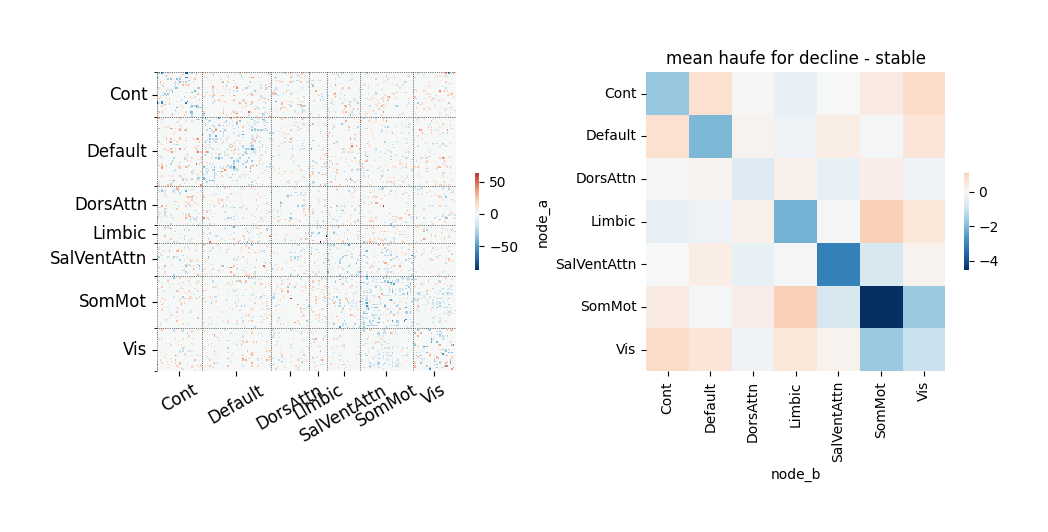

In [15]:
from neuroginius.matrices import MatrixResult

for class1, class2 in combinations(classes, 2):

    tmp_pvalues = p_values[class2, class1]
    # tmp_thresholded_mat = corrected_p_values[class2, class1]
    # tmp_ambient_mat = ambient_diff_matrices[class2, class1]
    tmp_tangent_mat = haufe_matrices.squeeze()
    # tmp_thresholded_mat = np.where(tmp_thresholded_mat < 0.05, tmp_thresholded_mat, 0)
    tmp_thresholded_mat = np.where(tmp_pvalues < 0.05, tmp_tangent_mat, 0)
    # tmp_thresholded_mat = -np.log(tmp_thresholded_mat)
    # plot_matrix(tmp_thresholded_mat, atlas, cmap='RdBu_r', vmin=0, vmax=1)
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 10))
    sns.heatmap(MatrixResult(tmp_thresholded_mat, atlas=atlas).sorted_matrix, square=True, 
                center=0,
                cmap='RdBu_r', ax=ax1, cbar_kws={'shrink': 0.1})
    set_network_ticks(ax1, atlas)
    sns.heatmap(MatrixResult(tmp_thresholded_mat, atlas=atlas).get_macro_matrix(), square=True, 
                center=0,
                cmap='RdBu_r', ax=ax2, cbar_kws={'shrink': 0.1})
    # set_network_ticks(ax1, atlas)
    plt.title(f"mean haufe for {class2} - {class1}")
    plt.tight_layout()



In [16]:
def multivariate_blocks(block):
    return (block,)

Calculating combined p-values for classes: decline - stable
zscore: -6.76,avg difference: -3.32, pvalue: 0.0000
zscore: 4.51,avg difference: 1.18, pvalue: 0.0000
zscore: 1.45,avg difference: 0.39, pvalue: 0.1470
zscore: -1.04,avg difference: -0.65, pvalue: 0.2970
zscore: -2.04,avg difference: -0.59, pvalue: 0.0410
zscore: 5.48,avg difference: 1.39, pvalue: 0.0000
zscore: 8.73,avg difference: 2.44, pvalue: 0.0000
zscore: -15.36,avg difference: -3.49, pvalue: 0.0000
zscore: 1.08,avg difference: 0.23, pvalue: 0.2779
zscore: -2.21,avg difference: -0.82, pvalue: 0.0273
zscore: 0.20,avg difference: 0.10, pvalue: 0.8384
zscore: 1.57,avg difference: 0.27, pvalue: 0.1174
zscore: 4.27,avg difference: 1.14, pvalue: 0.0000
zscore: -4.45,avg difference: -2.08, pvalue: 0.0000
zscore: 0.46,avg difference: 0.12, pvalue: 0.6435
zscore: 1.65,avg difference: 0.67, pvalue: 0.0989
zscore: 2.54,avg difference: 0.70, pvalue: 0.0110
zscore: 1.80,avg difference: 0.58, pvalue: 0.0712
zscore: -0.65,avg differenc

C:\Users\achil\AppData\Local\Temp\ipykernel_17384\3612413103.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


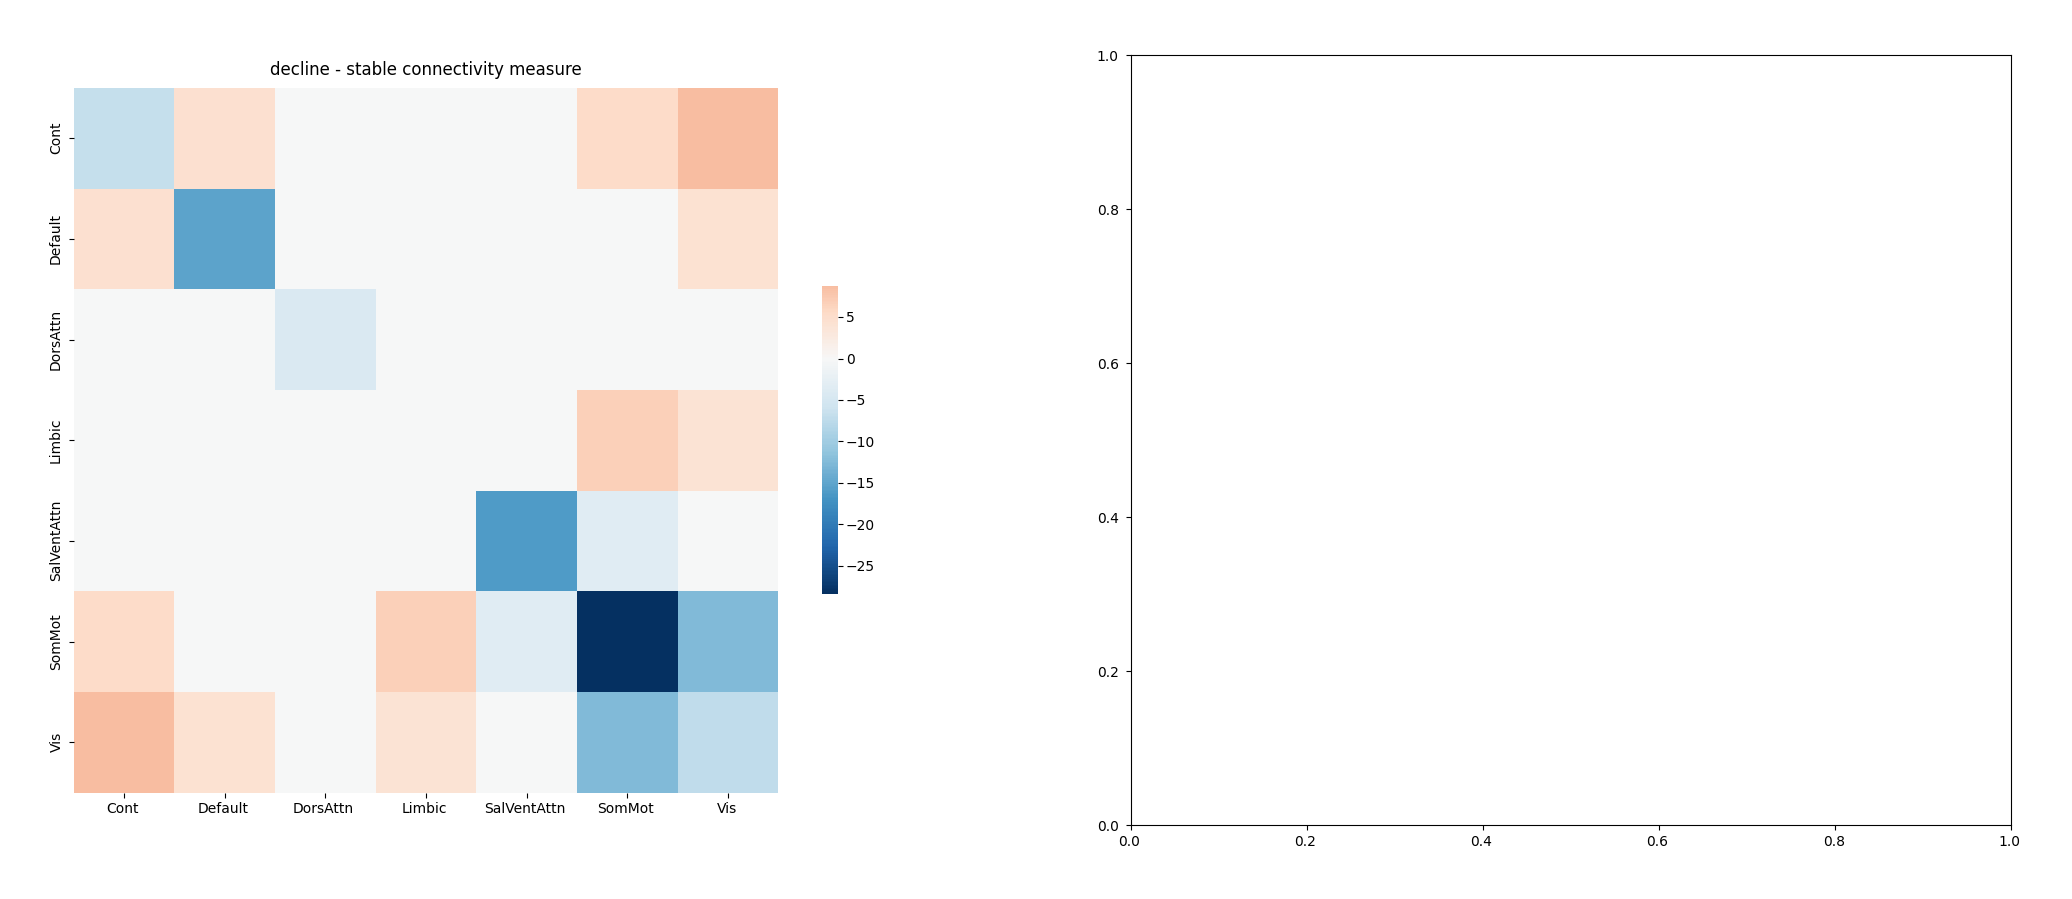

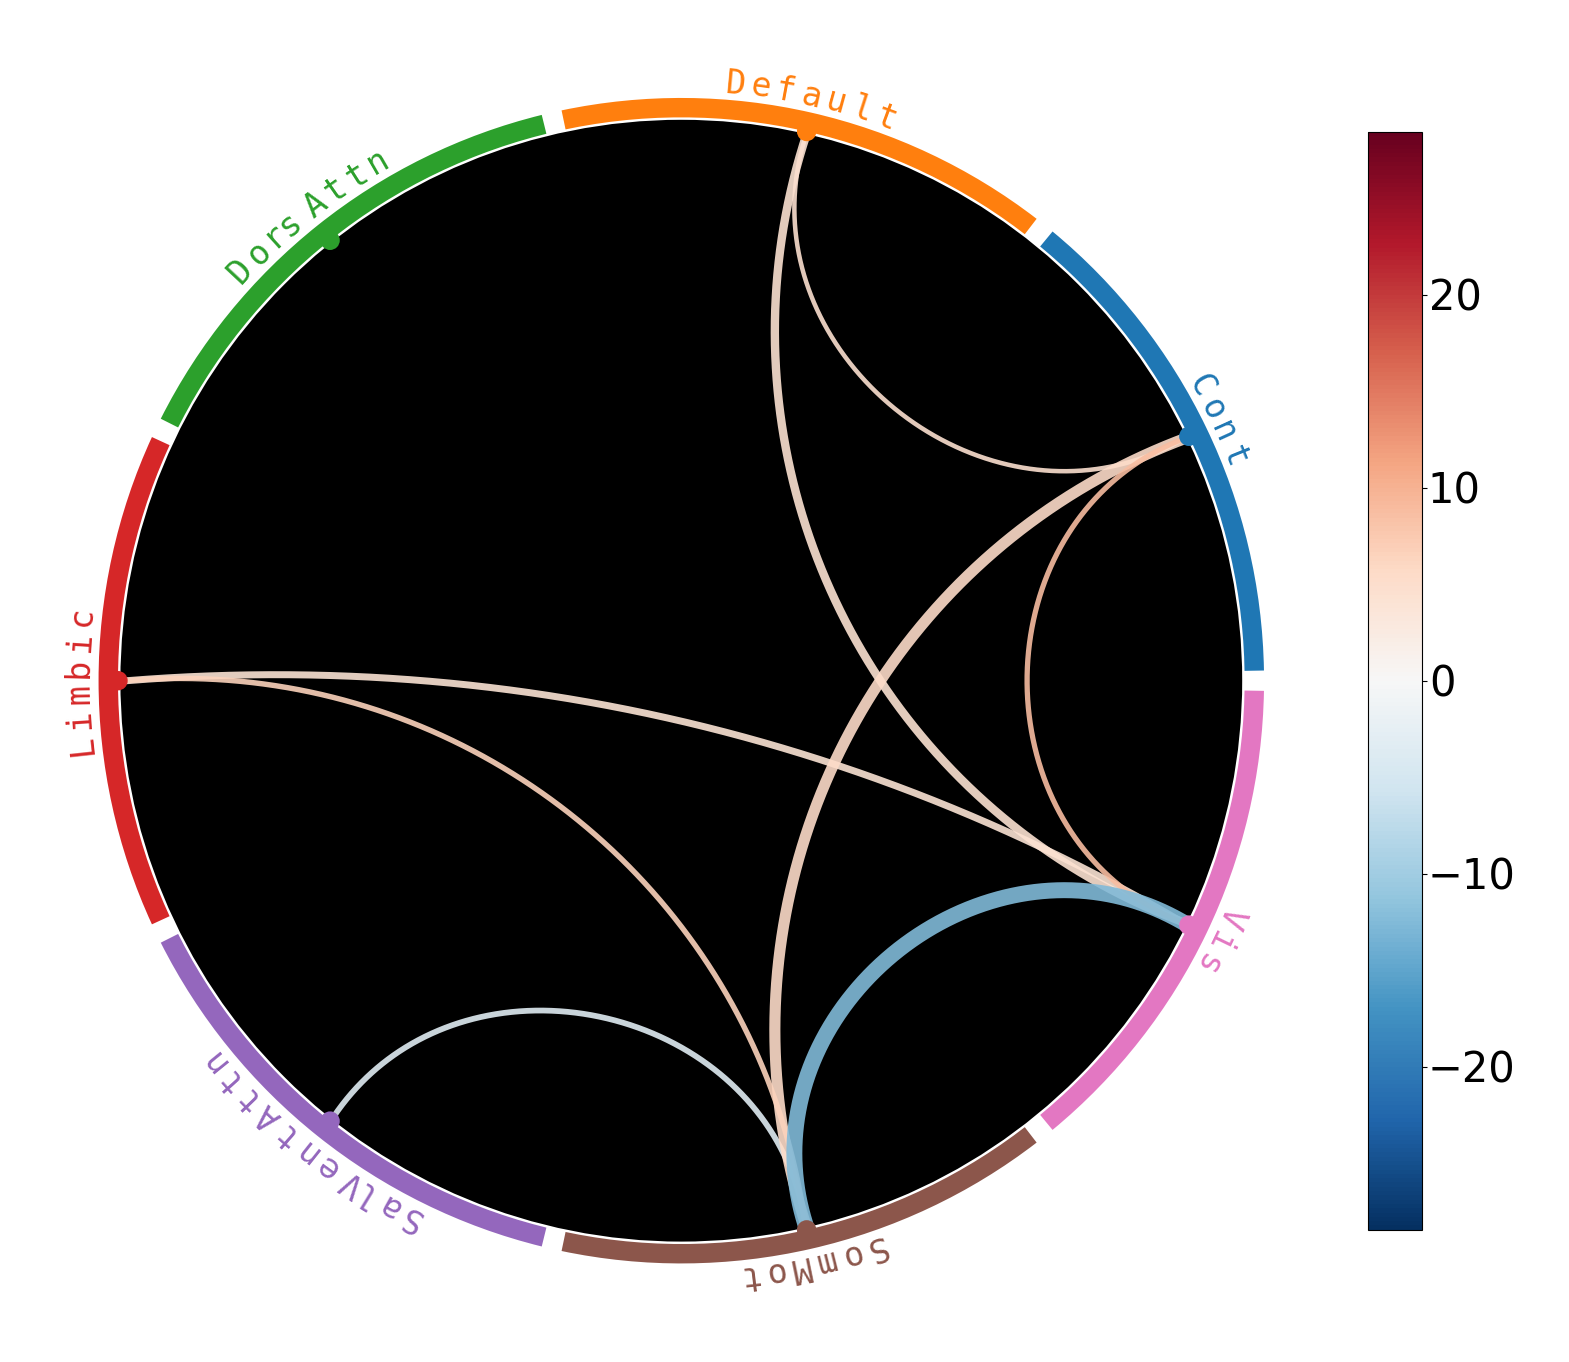

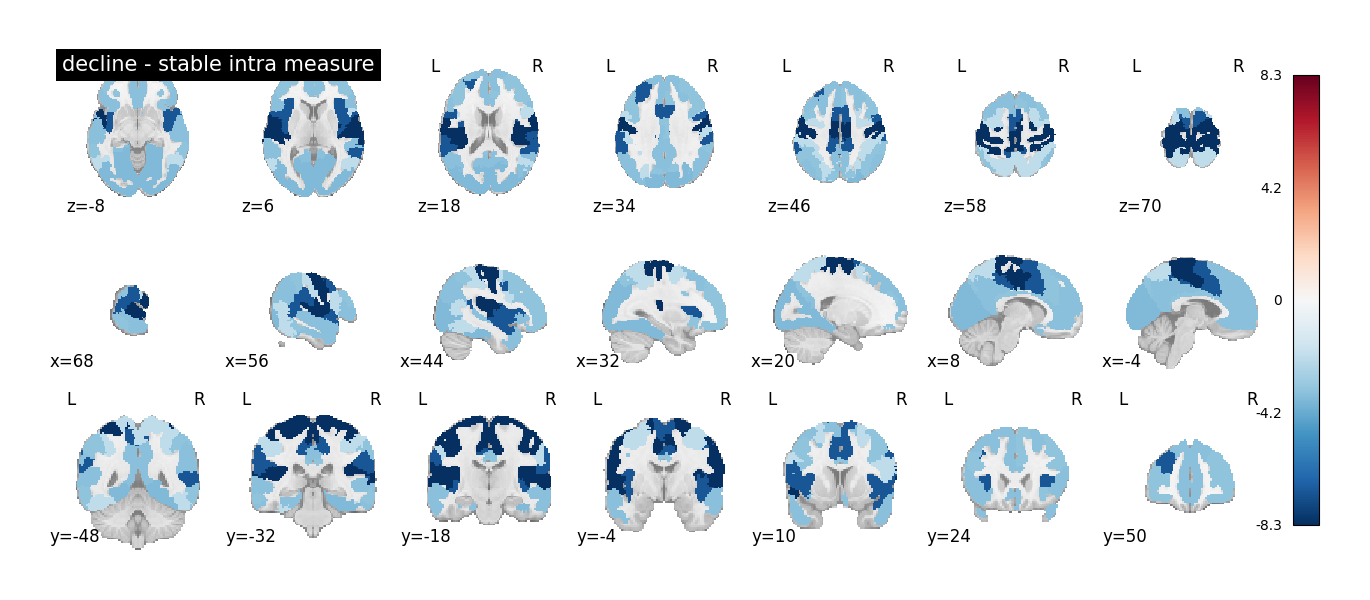

In [17]:
import numpy as np
from pycct import cct
from scipy.stats import combine_pvalues
from itertools import combinations_with_replacement
from statsmodels.stats.multitest import multipletests, fdrcorrection
fig, axs = plt.subplots(1, 2, figsize=(25, 10))
axs = axs.flatten()

masker = NiftiLabelsMasker(labels_img=atlas.maps)
masker.fit()

RSNs = np.unique(atlas.macro_labels)

blocks = list(combinations_with_replacement(RSNs, 2))
network_labels = atlas.macro_labels

# avoid numerical errors for z scores
p_values['decline', 'stable'] = np.clip(p_values['decline', 'stable'], 0, 0.9999)

print(f"Calculating combined p-values for classes: {class2} - {class1}")

tmp_pvalues = p_values[class2, class1].copy()
blocked_pvalues = MatrixResult(tmp_pvalues, atlas).get_macro_matrix(agg_func=multivariate_blocks)
# tmp_ambient_mat = ambient_diff_matrices[class2, class1]
tmp_tangent_mat = haufe_matrices.squeeze()
blocked_matrices = MatrixResult(tmp_tangent_mat, atlas).get_macro_matrix(agg_func=multivariate_blocks)

results = pd.DataFrame(index=RSNs, columns=RSNs, dtype=float)
tmp_results = []
zstat = []
for block_a, block_b in blocks:

    pvalues = blocked_pvalues.loc[block_a, block_b].copy().ravel()
    differences = blocked_matrices.loc[block_a, block_b].copy().ravel()

    # result = cct(pvalues)
    # result = combine_pvalues(pvalues, method='fisher', weights=weights)
    result = signed_stouffer(pvalues, differences)
    pvalue = result.pvalue
    tmp_results.append(pvalue)
    stat = result.statistic
    zstat.append(stat)
    # Use Lancaster's method to obtainsignedzscore
    # _, stat = lancaster(pvalues, weights)
    # stat = combine_pvalues(pvalues, method='stouffer', weights=weights).statistic
    print(f"zscore: {stat:.2f},avg difference: {differences.mean():.2f}, pvalue: {pvalue:.4f}")

# correction for multiple comparisons
pvalues_cor = multipletests(tmp_results, method='holm')[1]

for block_idx, (block_a, block_b) in enumerate(blocks):
    results.loc[block_a, block_b] = pvalues_cor[block_idx]
    results.loc[block_b, block_a] = pvalues_cor[block_idx]

significance_mask = np.where(results.values < 0.05, True, False)

tmp_tangent_mat_thresholded = np.where(tmp_pvalues, tmp_tangent_mat, 0)
block_thresholded_differences = MatrixResult(tmp_tangent_mat_thresholded, atlas=atlas).get_macro_matrix(lambda block: (block.mean(),))
block_thresholded_differences = block_thresholded_differences.where(significance_mask, 0)


result_to_plot = pd.DataFrame(to_matrix(zstat), 
                                index=RSNs, 
                                columns=RSNs)
result_to_plot = result_to_plot.where(significance_mask, 0)

matrix_to_chord(result_to_plot.values, atlas, percentile=None,
            diverging=True,
            positive_only=False,)


intra_results_vec = np.zeros(len(network_labels))
for idx, label in enumerate(network_labels):
    intra_results_vec[idx] = block_thresholded_differences.loc[label, label]

result_to_plot = pd.DataFrame(to_matrix(zstat), 
                                index=RSNs, 
                                columns=RSNs)
result_to_plot = result_to_plot.where(significance_mask, 0)
# result_to_plot = block_thresholded_differences
sns.heatmap(result_to_plot, center=0, cmap='RdBu_r', ax=axs[i],
            square=True,
            # vmax=15,
            cbar_kws={'shrink': 0.4}, annot=False)

axs[i].set_title(f"{class2} - {class1} connectivity measure")

intra_projected_results = masker.inverse_transform(intra_results_vec)

plot_stat_map(intra_projected_results, display_mode='mosaic', cmap='RdBu_r', 
                title=f"{class2} - {class1} intra measure", symmetric_cbar=True)

plt.tight_layout()
plt.show()

<Axes: xlabel='node_b', ylabel='node_a'>

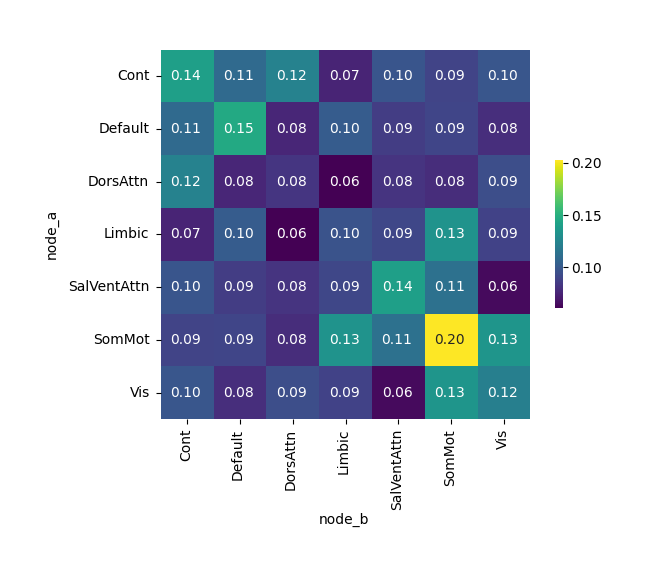

In [18]:
def count_significant(block):
    threshold = 0.05
    return (np.count_nonzero(block < 0.05) / block.size,)

pippo = MatrixResult(p_values['decline', 'stable'], atlas=atlas).get_macro_matrix(agg_func=count_significant)
sns.heatmap(pippo, cmap='viridis', annot=True, fmt=".2f", square=True, cbar_kws={'shrink': 0.4})


In [19]:
from scipy.spatial.distance import squareform
from nilearn.maskers import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas.maps, standardize=True, memory='nilearn_cache', verbose=5)
masker.fit()

[NiftiLabelsMasker.fit] loading data from 
C:\Users\achil\nilearn_data\schaefer_2018\Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

NiftiLabelsMasker(labels_img='C:\\Users\\achil\\nilearn_data\\schaefer_2018\\Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.nii.gz',
                  memory='nilearn_cache', standardize=True, verbose=5)

In [20]:
contrast = ('decline', 'stable')

tmp_diff_mat = diff_matrices[contrast]
tmp_null_diff_mats = null_diff_matrices[contrast]

In [31]:
def extract_anatomical_label(label):
    region_tags = str(label).split("_")
    if len(region_tags) == 4:
        return region_tags[2]
    return region_tags[3] + f" ({region_tags[2]})"


anatomical_labels = tuple(map(extract_anatomical_label, atlas.labels))
# anatomical_labels

In [32]:
unique_labels = np.unique(anatomical_labels)
mapping = {unique_labels[i]: i for i in range(len(unique_labels))}
anatomical_labels_int = pd.Series(anatomical_labels).map(mapping).values

[NiftiLabelsMasker.inverse_transform] computing image from signals

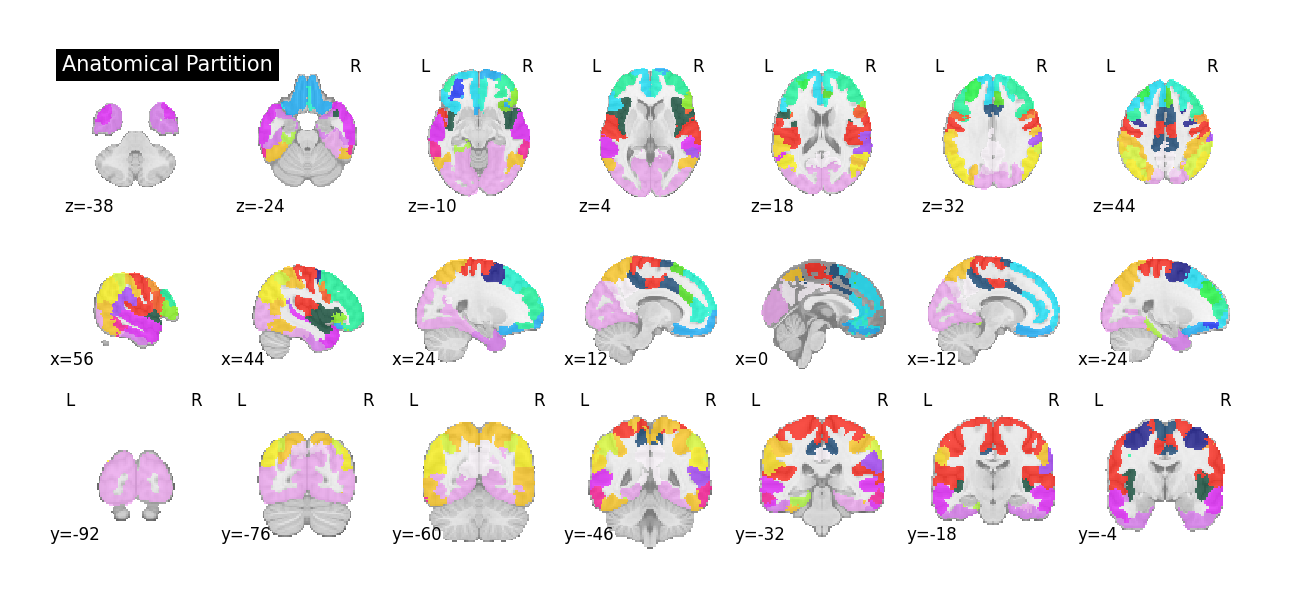

In [33]:
anatomical_atlas_map = masker.inverse_transform(anatomical_labels_int.astype(np.int32))

from nilearn.plotting import plot_roi
plot_roi(anatomical_atlas_map, title="Anatomical Partition", display_mode='mosaic')

In [34]:
class NiftiImageAtlas:
    def __init__(self, nifti_image, macro_labels=None):
        self.nifti_image = nifti_image
        self.labels = np.unique(nifti_image.get_fdata())
        if macro_labels is not None:
            self.macro_labels = macro_labels
        else:
            self.macro_labels = np.unique(self.labels)
        self.maps = nifti_image

    @classmethod
    def from_path(cls, path):
        from nilearn.image import load_img
        return cls(load_img(path))
    
anatomical_atlas = NiftiImageAtlas(anatomical_atlas_map, macro_labels=anatomical_labels)

Calculating combined p-values for classes: decline - stable


[NiftiLabelsMasker.inverse_transform] computing image from signals

[NiftiLabelsMasker.inverse_transform] computing image from signals

[NiftiLabelsMasker.inverse_transform] computing image from signals

C:\Users\achil\AppData\Local\Temp\ipykernel_17384\1401021444.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


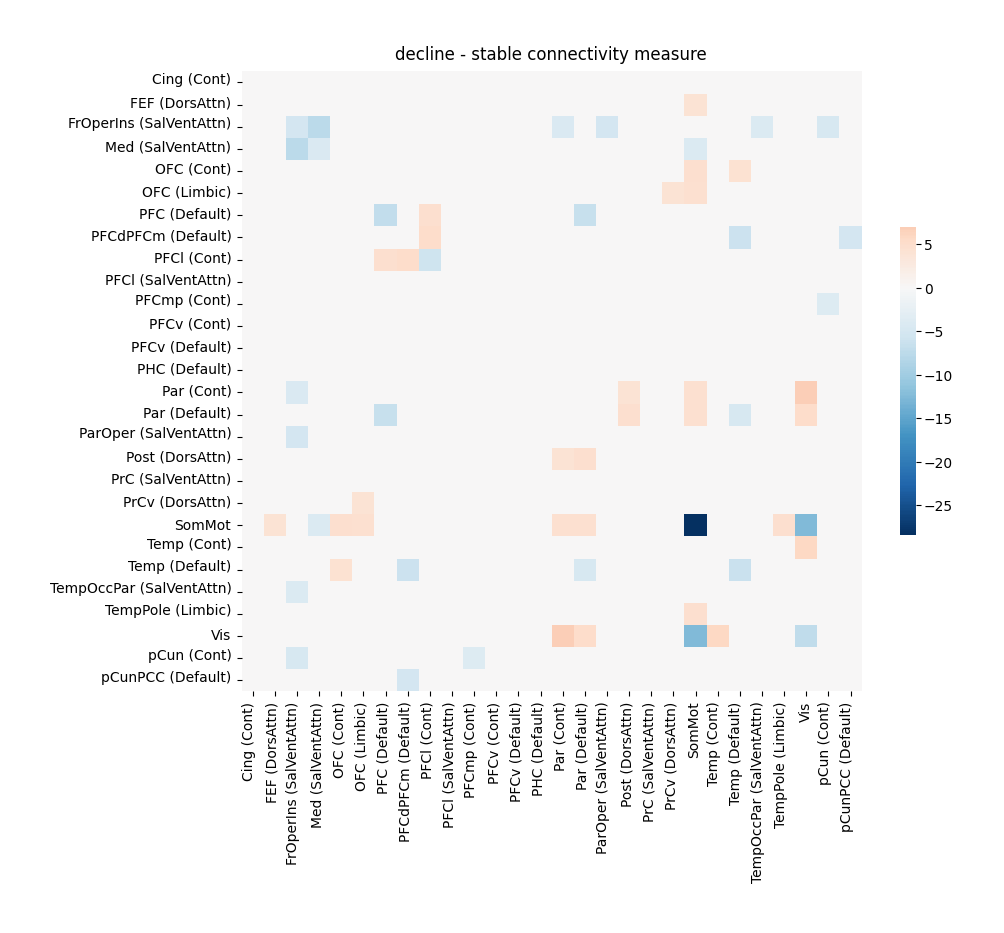

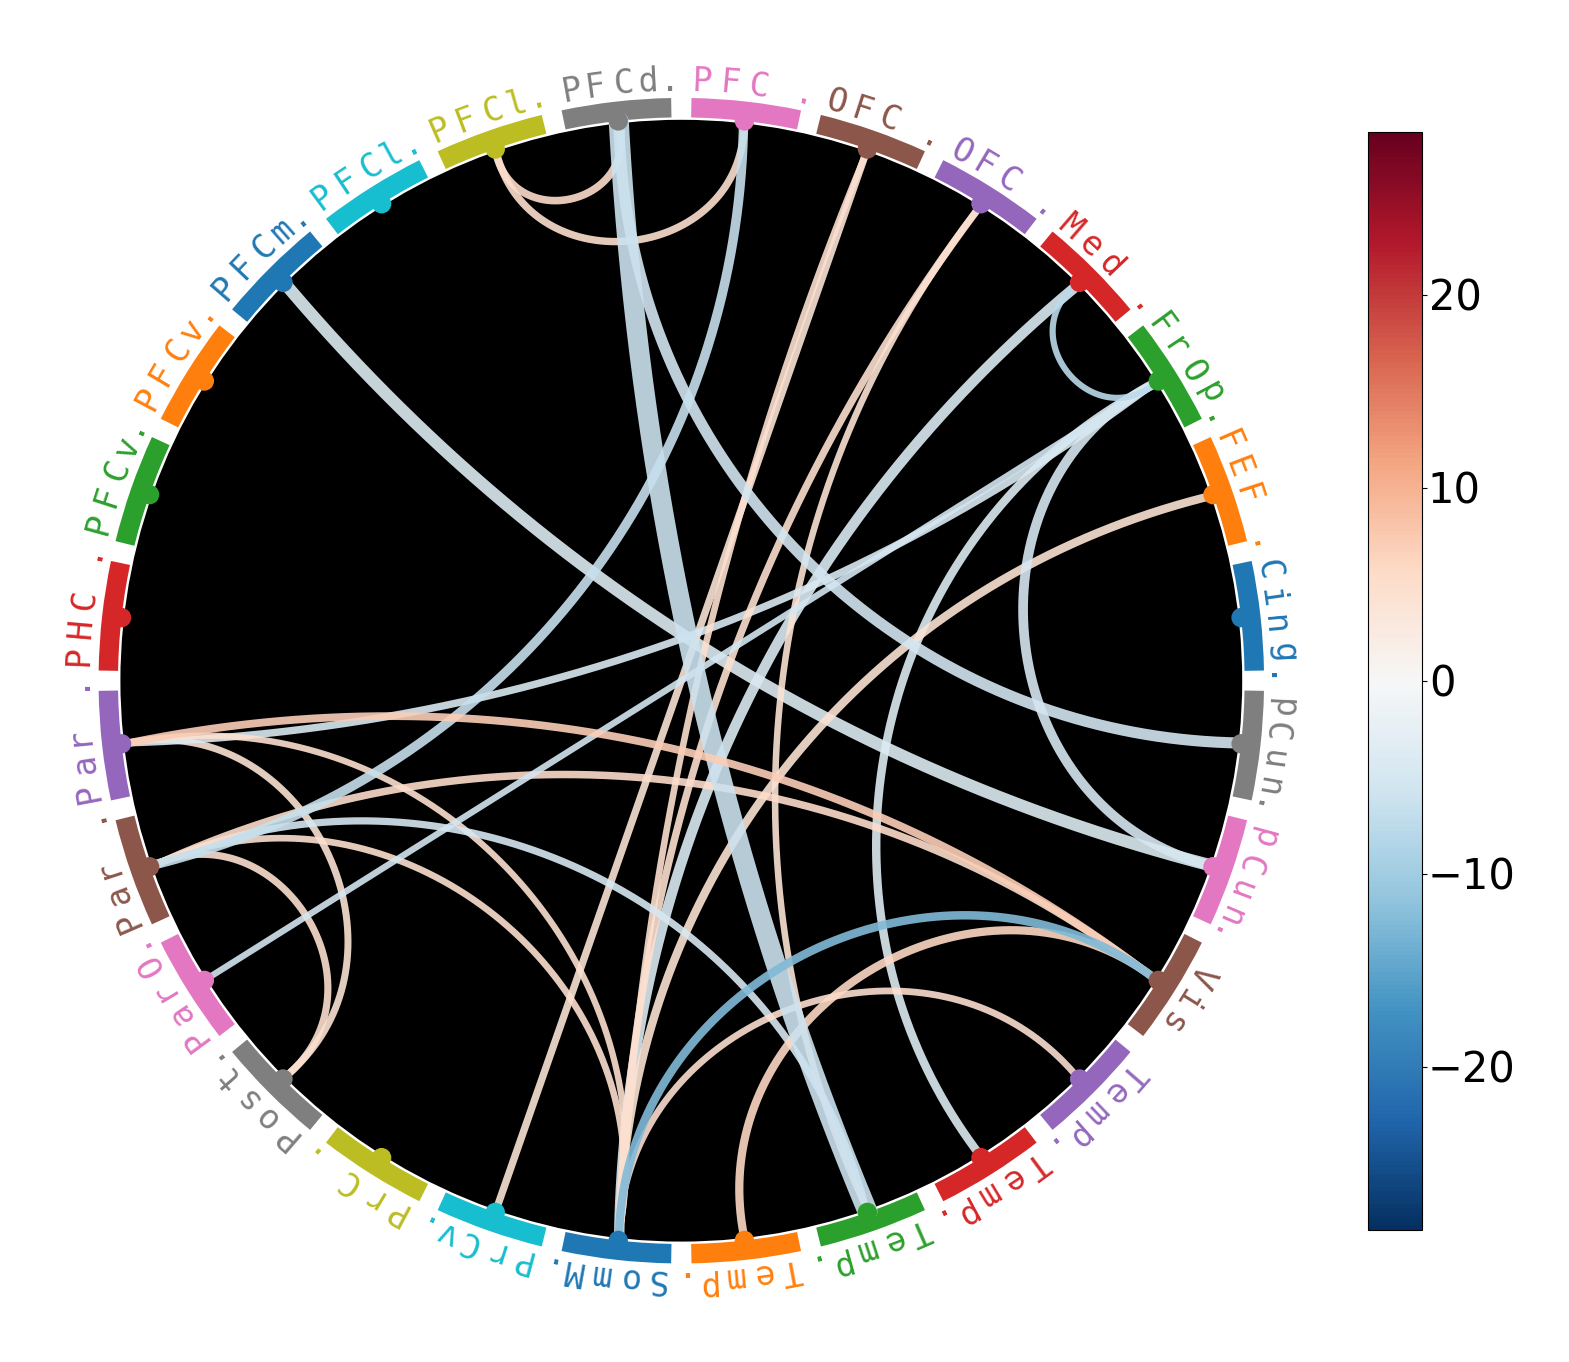

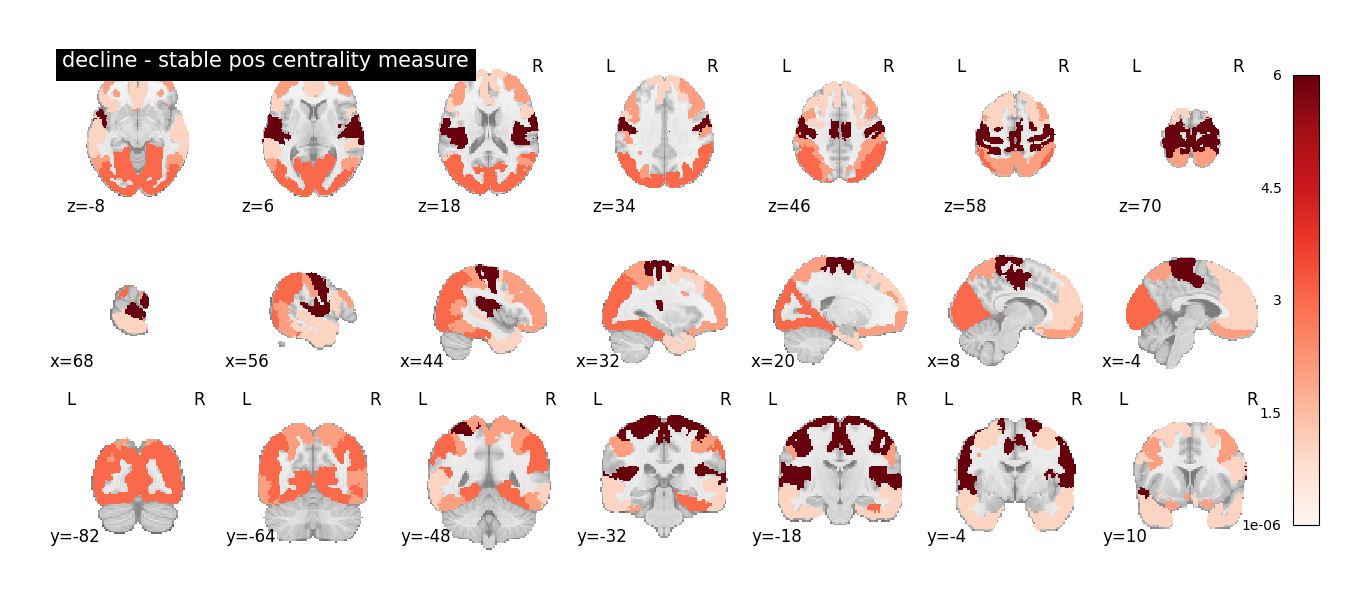

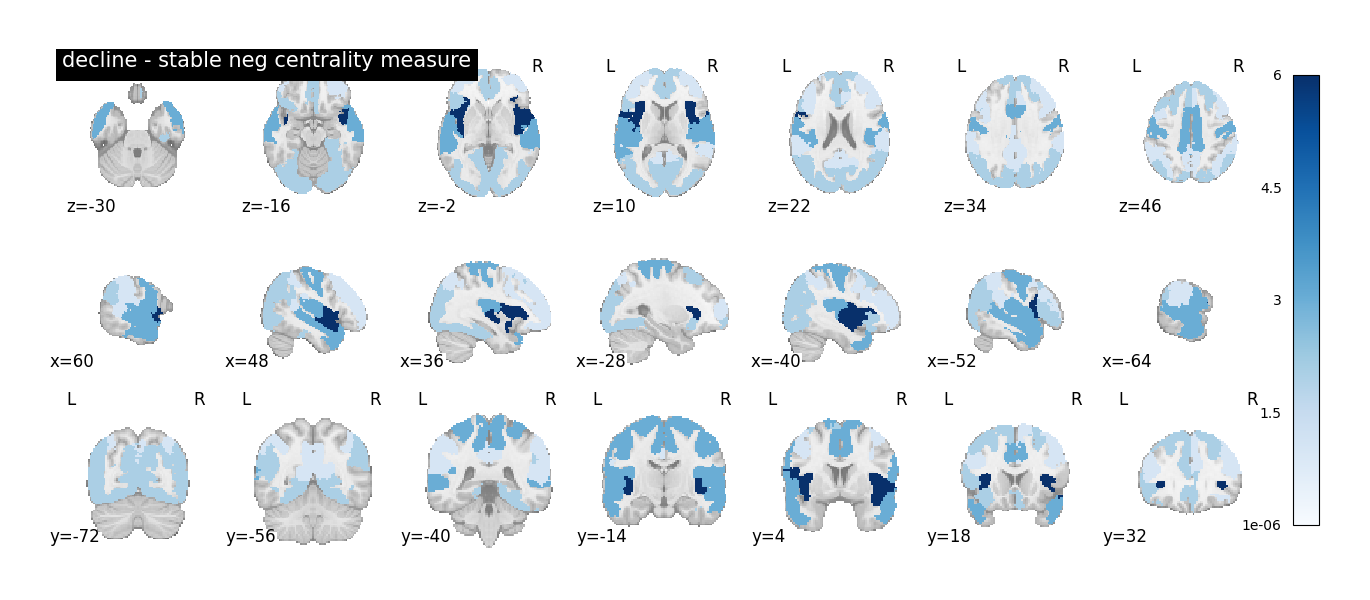

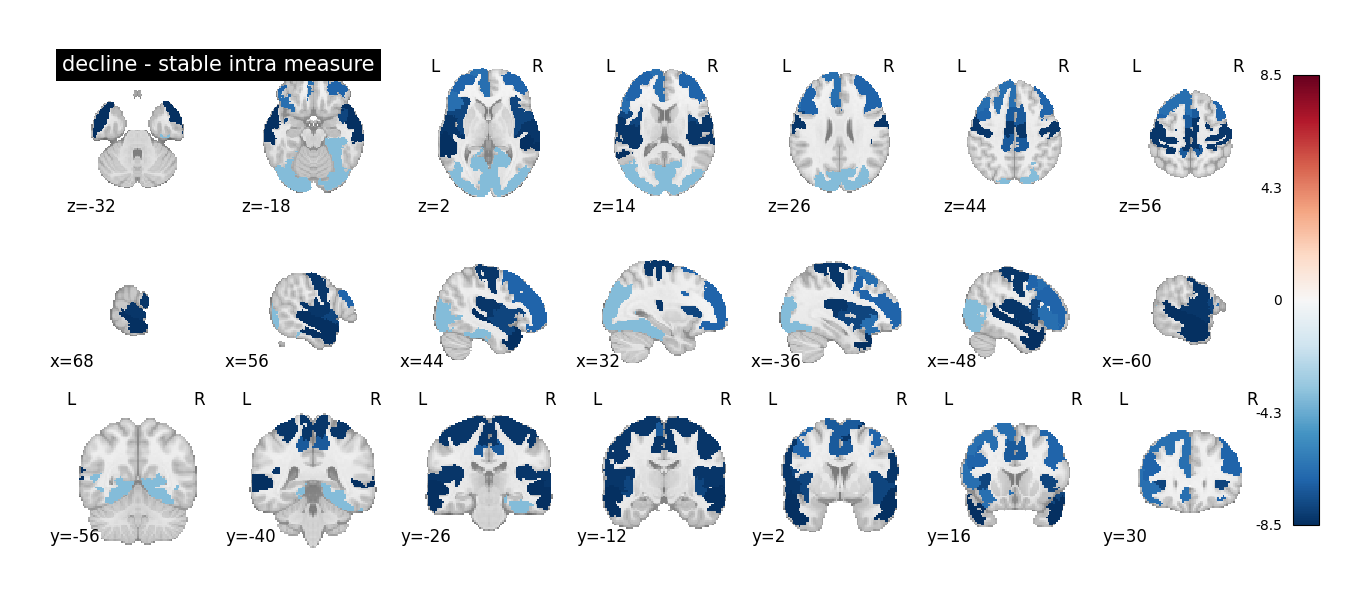

In [35]:
import numpy as np
from pycct import cct
from scipy.stats import combine_pvalues
from itertools import combinations_with_replacement
from statsmodels.stats.multitest import multipletests, fdrcorrection
from nilearn.connectome import vec_to_sym_matrix

anatomical_networks = np.unique(anatomical_labels)
blocks = list(combinations_with_replacement(anatomical_networks, 2))

final_blocklevel_results = {}

stacked_tangent_mats_thresholded = []
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
axs = [ax]

# avoid numerical errors for z scores
p_values['decline', 'stable'] = np.clip(p_values['decline', 'stable'], 0, 0.9999)


print(f"Calculating combined p-values for classes: {class2} - {class1}")

tmp_pvalues = p_values[class2, class1].copy()
tmp_mat = haufe_matrices.squeeze()
blocked_pvalues = MatrixResult(tmp_pvalues, anatomical_atlas).get_macro_matrix(agg_func=multivariate_blocks)
blocked_matrices = MatrixResult(tmp_mat, anatomical_atlas).get_macro_matrix(agg_func=multivariate_blocks)

results = pd.DataFrame(index=anatomical_networks, columns=anatomical_networks, dtype=float)
tmp_results = []
zstat = []
for block_a, block_b in blocks:

    pvalues = blocked_pvalues.loc[block_a, block_b].copy().ravel()
    differences = blocked_matrices.loc[block_a, block_b].copy().ravel()

    # result = cct(pvalues)
    # result = combine_pvalues(pvalues, method='fisher', weights=weights)
    result = signed_stouffer(pvalues, differences)
    pvalue = result.pvalue
    tmp_results.append(pvalue)
    stat = result.statistic
    zstat.append(stat)
    # Use Lancaster's method to obtainsignedzscore
    # _, stat = lancaster(pvalues, weights)
    # stat = combine_pvalues(pvalues, method='stouffer', weights=weights).statistic
    # print(f"zscore: {stat:.2f},avg difference: {differences.mean():.2f}, pvalue: {pvalue:.4f}")

# correction for multiple comparisons
result_cor = multipletests(tmp_results, method='holm')[1]

for block_idx, (block_a, block_b) in enumerate(blocks):
    results.loc[block_a, block_b] = result_cor[block_idx]
    results.loc[block_b, block_a] = result_cor[block_idx]

significance_mask = np.where(results.values < 0.05, True, False)

tmp_mat_thresholded = np.where(tmp_pvalues, tmp_mat, 0)
stacked_tangent_mats_thresholded.append(tmp_mat_thresholded[np.triu_indices(200, k=1)].ravel())
block_thresholded_mat = MatrixResult(tmp_mat_thresholded, atlas=anatomical_atlas).get_macro_matrix(lambda block: (block.mean(),))
block_thresholded_mat = block_thresholded_mat.where(significance_mask, 0)

result_to_plot = pd.DataFrame(to_matrix(zstat), 
                                index=anatomical_networks, 
                                columns=anatomical_networks)
result_to_plot = result_to_plot.where(significance_mask, 0)

matrix_to_chord(result_to_plot.values, anatomical_atlas, percentile=None,
            diverging=True,
            positive_only=False,)

pos_centrality, neg_centrality = degree_centrality(block_thresholded_mat)
pos_results_vec = np.zeros(len(anatomical_labels))
neg_results_vec = np.zeros(len(anatomical_labels))
for idx, label in enumerate(anatomical_labels_int):
    pos_results_vec[idx] = pos_centrality[label]
    neg_results_vec[idx] = neg_centrality[label]

intra_results_vec = np.zeros(len(anatomical_labels))
for idx, label in enumerate(anatomical_labels):
    intra_results_vec[idx] = block_thresholded_mat.loc[label, label]

result_to_plot = pd.DataFrame(to_matrix(zstat), 
                                index=anatomical_networks, 
                                columns=anatomical_networks)
result_to_plot = result_to_plot.where(significance_mask, 0)
# result_to_plot = block_thresholded_differences
sns.heatmap(result_to_plot, center=0, cmap='RdBu_r', ax=axs[i],
            square=True,
            # vmax=15,
            cbar_kws={'shrink': 0.4}, annot=False)

axs[i].set_title(f"{class2} - {class1} connectivity measure")

pos_projected_results = masker.inverse_transform(pos_results_vec)
neg_projected_results = masker.inverse_transform(neg_results_vec)
intra_projected_results = masker.inverse_transform(intra_results_vec)

plot_stat_map(pos_projected_results, display_mode='mosaic', cmap='Reds', 
                title=f"{class2} - {class1} pos centrality measure", symmetric_cbar=False)
plot_stat_map(neg_projected_results, display_mode='mosaic', cmap='Blues', 
                title=f"{class2} - {class1} neg centrality measure", symmetric_cbar=False)
plot_stat_map(intra_projected_results, display_mode='mosaic', cmap='RdBu_r', 
                title=f"{class2} - {class1} intra measure", symmetric_cbar=True)
intra_projected_results.to_filename(f"tmp_intra_projection_{class2}_{class1}.nii.gz")

plt.tight_layout()
plt.show()